# Прогнозирование вероятности оттока клиентов сети фитнес-центров

# Описание данных
Данные клиента за предыдущий до проверки факта оттока месяц:
- gender — пол;
- Near_Location — проживание или работа в районе, где находится фитнес-центр;
- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- Phone — наличие контактного телефона;
- Age — возраст;
- Lifetime  — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
- Group_visits — факт посещения групповых занятий;
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

Churn — факт оттока в текущем месяце.

# Цель работы
Провести анализ и подготовить план действий по удержанию клиентов.

# План
- Шаг 1. Загрузка данных
- Шаг 2. Провести исследовательский анализ данных (EDA)
- Шаг 3. Построить модель прогнозирования оттока клиентов
- Шаг 4. Сделать кластеризацию клиентов
- Шаг 5. Общий вывод и базовые рекомендации по работе с клиентами.

# Шаг 1. Загрузка данных

In [1]:
# выгружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.shape

(4000, 14)

In [4]:
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


# Шаг 2. Исследовательский анализ данных (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Предварительная оценка данных показала, что в датасете нет пропусков, все значения числовые, что облегчит задачу по построению модели прогнозирования оттока.

In [6]:
df.columns = df.columns.str.lower() # приводим к нижнему регистру

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [8]:
# округлим числовые значения до сотых
pd.options.display.float_format = '{:,.2f}'.format

In [9]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


- Клиенты имеют возраст от 18 до 41 года(в среднем - 29 лет)
- В основном клиенты предпочитают приобретать абонементы на 1 месяц
- Разделение клиентов по полу примерно равное
- Почти 85 процентов живут в районе где расположен фитнес-центр
- Групповые занятия посещали около 40%
- Средний отток пользователей около 27%.

In [10]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


- Пользователи которые ушли меньше пользовались групповыми тренировками
- Разница между группами 3 года
- Пол и локация особо не влияют на отток клиентов.

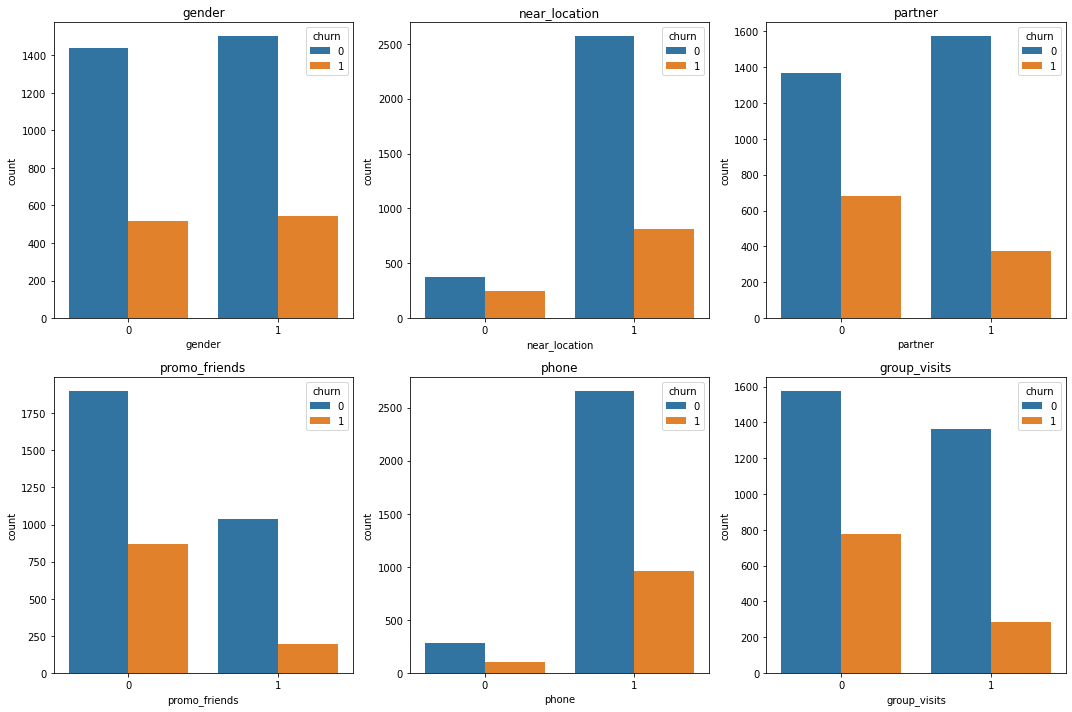

In [11]:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

a = 2
b = 3
c = 1

fig = plt.figure(figsize=(15,10))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.countplot(data=df, x=df[i], hue='churn')
    c = c + 1

plt.tight_layout()
plt.show()

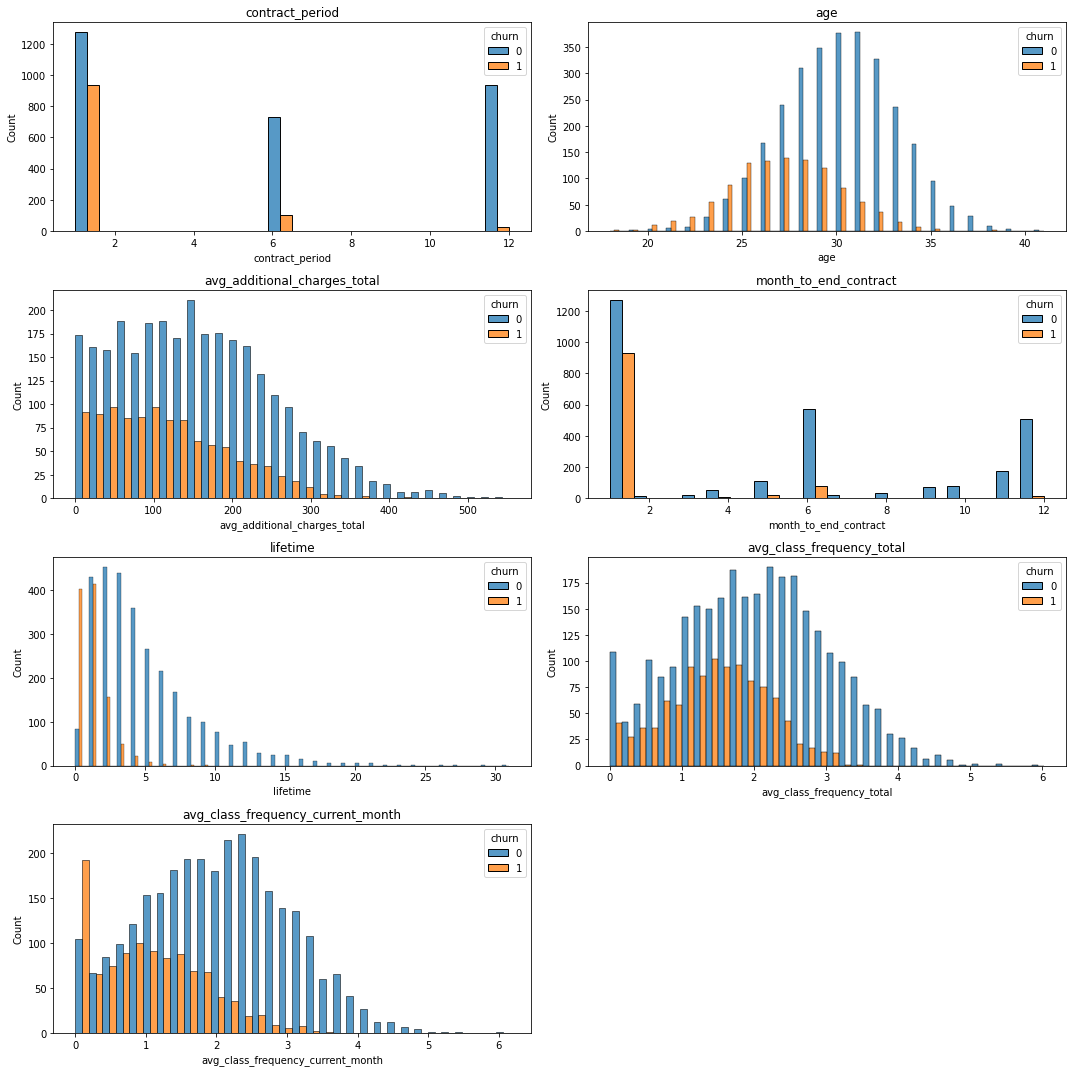

In [12]:
columns = ['contract_period',
           'age',
           'avg_additional_charges_total',
           'month_to_end_contract',
           'lifetime',
           'avg_class_frequency_total',
           'avg_class_frequency_current_month']

a = 4
b = 2
c = 1

fig = plt.figure(figsize=(15,15))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.histplot(x = df[i],
                hue='churn',
                data=df,
                multiple='dodge')
    c = c + 1

plt.tight_layout()
plt.show()

- Среди посещающих зал, и среди ушедних - распределение полов одинаково
- Среди ушедших клиентов доля проживающих недалеко от зала ниже, чем у тех, кто его посещает
- ушедшие клиенты практически не пользовались программой "приведи друга". Партнерская программа также представлена меньше в этой группе, нежели у постоянных посетителей
- Большая часть ушедших клиентов имеют очень короткие абонементы и не посещают групповые занятия
- Ушедшие пользователи в среднем посещают зал в 2 раза реже, чем постоянные.

В итоге можно сказать, что больше всего ушедших - это люди до 30 лет, с малым периодом контракта и пришедших не по промоакциям, и реже посещающих групповые занятия.

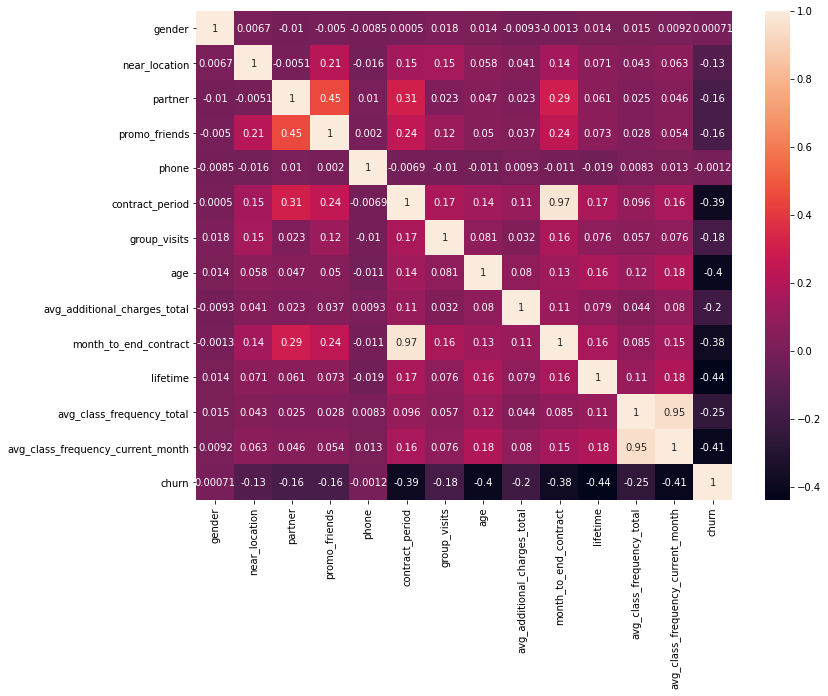

In [13]:
cm = df.corr()


plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True)

plt.show()

При визуализации матрицы корреляции видно, что имеются:

- мультиколлинеарные признаки: 'avg_class_frequency_total' - 'avg_class_frequency_current_month', 'contract_period' - 'month_to_end_contract'.

- признаки с близкой к нулю корреляцией с целевой переменной: 'gender', 'phone'.

# Вывод:
Предварительная оценка данных показала, что в датасете нет пропусков, все значения числовые, что облегчит задачу по построению модели прогнозирования оттока.

- Клиенты имеют возраст от 18 до 41 года(в среднем - 29 лет)
- В основном клиенты предпочитают приобретать абонементы на 1 месяц
- Почти 85 процентов живут в районе где расположен фитнес-центр
- Групповые занятия посещали около 40%
- Средний отток пользователей около 27%
- Пользователи которые ушли меньше пользовались групповыми тренировками
- Разница между группами 3 года
- Пол и локация особо не влияют на отток клиентов
- Среди посещающих зал, и среди ушедних - распределение полов одинаково
- Среди ушедших клиентов доля проживающих недалеко от зала ниже, чем у тех, кто его посещает
- ушедшие клиенты практически не пользовались программой "приведи друга". Партнерская программа также представлена меньше в этой группе, нежели у постоянных посетителей
- Большая часть ушедших клиентов имеют очень короткие абонементы и не посещают групповые занятия
- Ушедшие пользователи в среднем посещают зал в 2 раза реже, чем постоянные.

При визуализации матрицы корреляции видно, что имеются:

- мультиколлинеарные признаки: 'avg_class_frequency_total' - 'avg_class_frequency_current_month', 'contract_period' - 'month_to_end_contract'.

- признаки с близкой к нулю корреляцией с целевой переменной: 'gender', 'phone'.

В итоге можно сказать, что больше всего ушедших - это люди до 30 лет, с малым периодом контракта и пришедших не по промоакциям, и реже посещающих групповые занятия

# Шаг 3. Построим модель прогнозирования оттока клиентов

Разбейте данные на обучающую и валидационную выборку функцией train_test_split().

In [14]:
#Разделим  данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

In [15]:
#Разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Логистическая регрессия

In [16]:
# Зададим алгоритм для модели
logistic_model = LogisticRegression(random_state=0)
# Обучим модель
logistic_model.fit(X_train_st, y_train)
# Воспользуемся обученной моделью, чтобы сделать прогнозы
logistic_predictions = logistic_model.predict(X_test_st)

# выводим метрики
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83


Случайный лес

In [17]:
# Зададим алгоритм для модели
r_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# Обучим модель
r_forest_model.fit(X_train_st, y_train)
# Воспользуемся обученной моделью, чтобы сделать прогнозы
r_forest_predictions = r_forest_model.predict(X_test_st)

# выводим метрики
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, r_forest_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, r_forest_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, r_forest_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81


# Вывод:
Модель логистической регрессии показала себя немного лучше.

# Шаг 4. Сделаем кластеризацию клиентов

In [18]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# #Строим матрицу
linked = linkage(X_sc, method = 'ward')

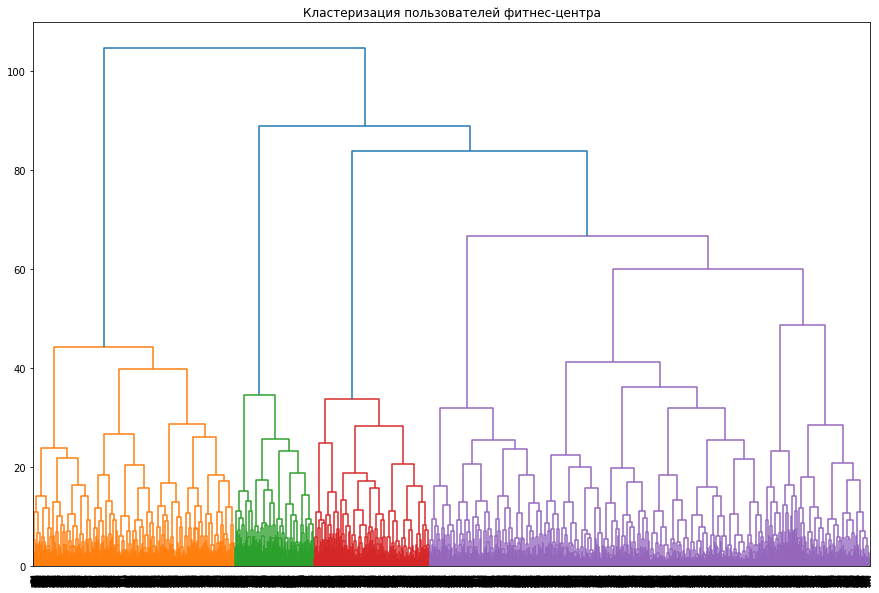

In [19]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-центра')

plt.show() 

Разными цветами дендрограмма разбивается на 4 кластера.

In [20]:
# Зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# Спрогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# Сохраним метки кластера в поле нашего датасета
df['cluster_km'] = labels

# Выведем средние значения признаков для кластеров
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


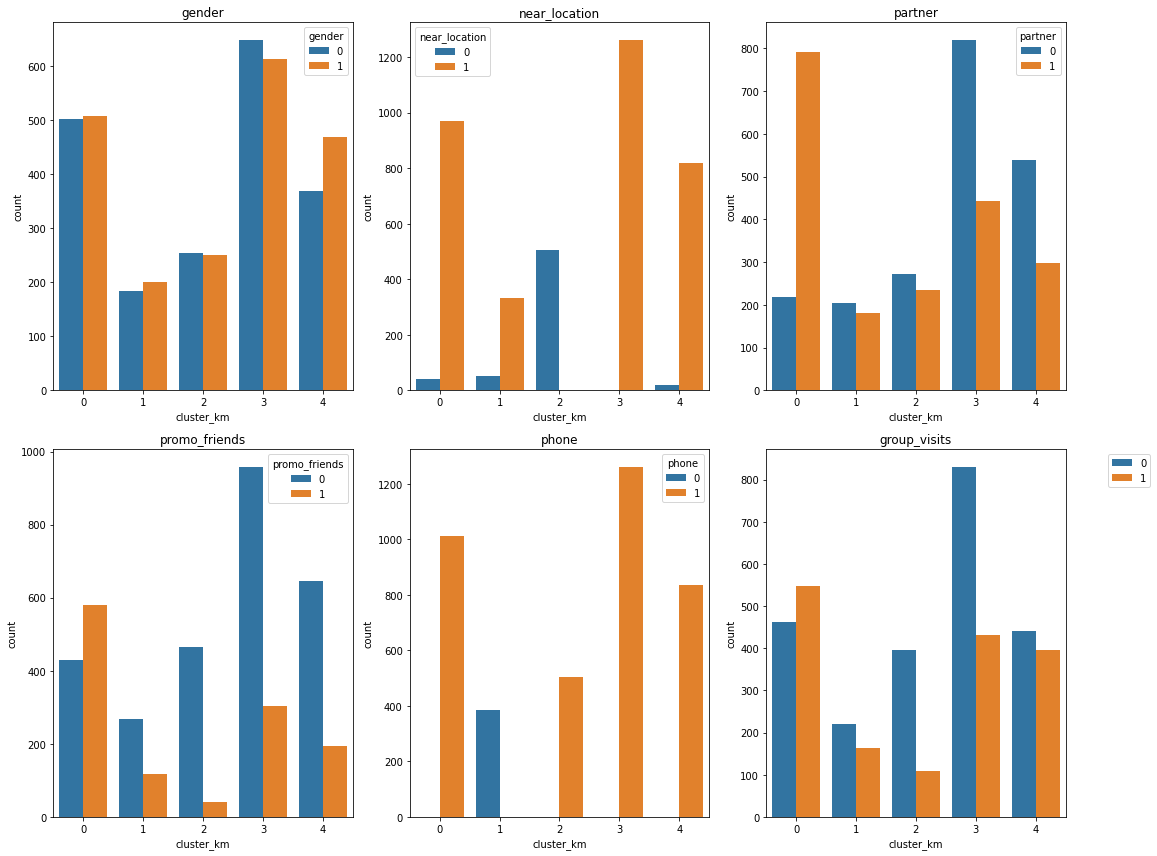

In [21]:
# построим countplot-графики для бинарных признаков
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

a = 2
b = 3
c = 1

fig = plt.figure(figsize=(15,12))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.countplot(data=df, x='cluster_km', hue=df[i])
    c = c + 1

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()

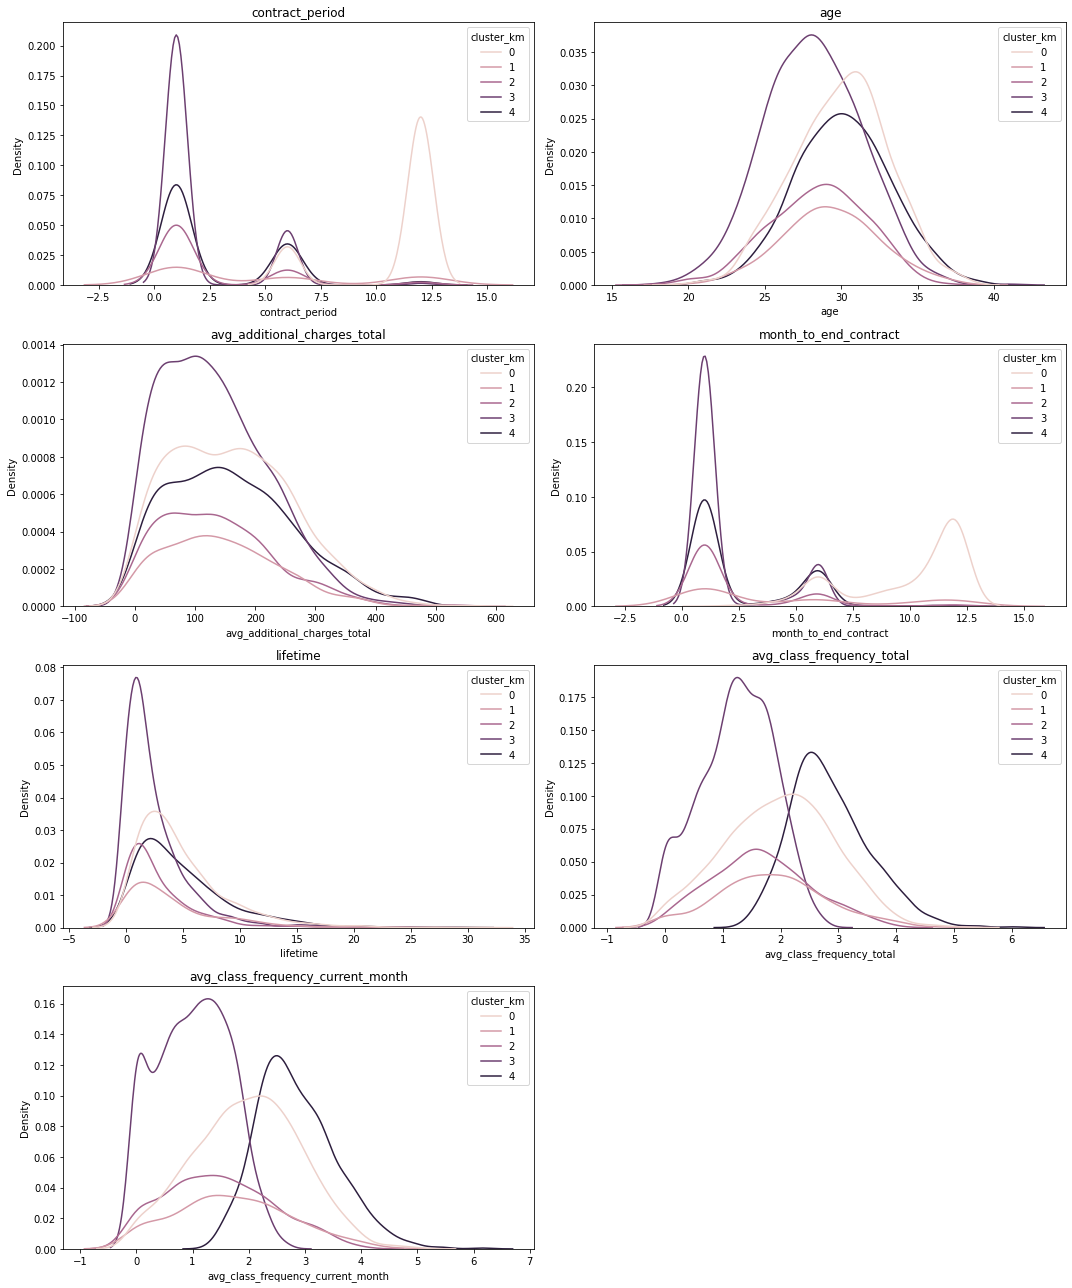

In [22]:
# построим kdeplot-графики для небинарных признаков
columns = ['contract_period',
           'age',
           'avg_additional_charges_total',
           'month_to_end_contract',
           'lifetime',
           'avg_class_frequency_total',
           'avg_class_frequency_current_month']

a = 4
b = 2
c = 1

fig = plt.figure(figsize=(15,18))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.kdeplot(x = df[i],
                hue='cluster_km',
                data=df)
    c = c + 1

plt.tight_layout()
plt.show()

In [23]:
df.groupby('cluster_km').agg({'churn':'mean'}).sort_values(by='churn')

,churn
cluster_km,
0,0.03
4,0.07
1,0.27
2,0.44
3,0.51


# Вывод:
## Кластер 0:
- Доля оттока составляет около 3%
- Большая часть клиентов данного кластера является партнерами клуба
- Средняя длительность действующих абониментов составляет примерно 11 месяцев
- До окончания действия абонимента в среднем 10 месяцев
## Кластер 1:
- Доля оттока составляет около 27%
- Никто из клиентов в данном кластере не оставил телефон для контактов
## Кластер 2:
- Доля оттока составляет около 44%
- Никто из клиентов в данном кластере не живет или не работает в районе расположения клуба
- Наименьший процент клиентов, посещавших групповые тренировки
- Практически все клиенты этого кластера пришли без приглашения от друга
## Кластер 3:
- Доля оттока составляет около 51%
- Все клиенты из данного кластера находятся недалеко от клуба
- Длительность абонемента менее 2 месяцев
- Наименьшие расходы на дополнительные услуги клуба
## Кластер 4:
- Доля оттока составляет около 7%
- Наибольшие расходы на дополнительные услуги клуба
- lifetime почти 5 месяцев
- Средняя частота посещений зала - около 3 раз в неделю.

Пол и возраст практически не влияют на распределение.

# Шаг 5. Общий вывод и базовые рекомендации по работе с клиентами

Предварительная оценка данных показала, что в датасете нет пропусков, все значения числовые, что облегчит задачу по построению модели прогнозирования оттока.

- Клиенты имеют возраст от 18 до 41 года(в среднем - 29 лет)
- В основном клиенты предпочитают приобретать абонементы на 1 месяц
- Почти 85 процентов живут в районе где расположен фитнес-центр
- Групповые занятия посещали около 40%
- Средний отток пользователей около 27%
- Пользователи которые ушли меньше пользовались групповыми тренировками
- Разница между группами 3 года
- Пол и локация особо не влияют на отток клиентов
- Среди посещающих зал, и среди ушедних - распределение полов одинаково
- Среди ушедших клиентов доля проживающих недалеко от зала ниже, чем у тех, кто его посещает
- ушедшие клиенты практически не пользовались программой "приведи друга". Партнерская программа также представлена меньше в этой группе, нежели у постоянных посетителей
- Большая часть ушедших клиентов имеют очень короткие абонементы и не посещают групповые занятия
- Ушедшие пользователи в среднем посещают зал в 2 раза реже, чем постоянные.

При визуализации матрицы корреляции видно, что имеются:

- мультиколлинеарные признаки: 'avg_class_frequency_total' - 'avg_class_frequency_current_month', 'contract_period' - 'month_to_end_contract'.

- признаки с близкой к нулю корреляцией с целевой переменной: 'gender', 'phone'.

В итоге можно сказать, что больше всего ушедших - это люди до 30 лет, с малым периодом контракта и пришедших не по промоакциям, и реже посещающих групповые занятия

Кластер 0:
- Доля оттока составляет около 3%
- Большая часть клиентов данного кластера является партнерами клуба
- Средняя длительность действующих абониментов составляет примерно 11 месяцев
- До окончания действия абонимента в среднем 10 месяцев

Кластер 1:

- Доля оттока составляет около 27%
- Никто из клиентов в данном кластере не оставил телефон для контактов

Кластер 2:

- Доля оттока составляет около 44%
- Никто из клиентов в данном кластере не живет или не работает в районе расположения клуба
- Наименьший процент клиентов, посещавших групповые тренировки
- Практически все клиенты этого кластера пришли без приглашения от друга

Кластер 3:

- Доля оттока составляет около 51%
- Все клиенты из данного кластера находятся недалеко от клуба
- Длительность абонемента менее 2 месяцев
- Наименьшие расходы на дополнительные услуги клуба

Кластер 4:

- Доля оттока составляет около 7%
- Наибольшие расходы на дополнительные услуги клуба
- lifetime почти 5 месяцев
- Средняя частота посещений зала - около 3 раз в неделю.

Пол и возраст практически не влияют на распределение.

# Рекомендации по работе с клиентами

- Собирать контактные данные клиентов для рассылок и специальных предложений
- Стимулировать имеющихся клиентов приглашать своих друзей и коллег по промокодам
- Снизить стоимость для групповых занятий и постараться сделать их более доступными
- Добавить привилегии для долгосрочных абонементов